# LSTM-AE for Anomaly Detection in Time Series Data

## Import Libraries

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from pathlib import Path
from sklearn.model_selection import train_test_split


## LSTM for Conductivity

### Data preprocessing

In [14]:
# This folder contains all files w/ metrics
data_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
train_c_filename = 'train_c_bootstrap.csv'
valid_c_filename = 'valid_c_data.csv'

In [21]:
# import data file
train_c = pd.read_csv(data_path/train_c_filename)
train_c['timestamp'] = train_c.index

valid_c = pd.read_csv(data_path/valid_c_filename)
valid_c['timestamp'] = valid_c.index

In [28]:
# Let's make it function for further usage
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None):
    #df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['stand_value'] = df[df.columns[1]]
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

def de_meaning(df: pd.DataFrame):
    run_list = df['run_id'].unique()
    df_list = []
    for run in run_list:
        run_df = df[df['run_id']==run].copy()
        mean = run_df['conductivity'].mean()
        run_df['conductivity'] = run_df['conductivity'] - mean
        df_list.append(run_df)
    dm_df = pd.concat(df_list, axis=0)
    return dm_df
        

In [29]:
train_conduct = train_c.copy().loc[:, ['timestamp', 'conductivity', 'run_id']]
valid_conduct = valid_c.copy().loc[:, ['timestamp', 'conductivity', 'run_id', 'anomaly_label']]
valid_conduct = de_meaning(valid_conduct)
print(train_conduct.head())
print(valid_conduct.head())

   timestamp  conductivity run_id
0          0     -0.014357  run_0
1          1      0.125643  run_0
2          2      0.125643  run_0
3          3      0.125643  run_0
4          4     -0.094357  run_0
   timestamp  conductivity    run_id  anomaly_label
0          0     -0.141503  JUL_22_6              0
1          1     -0.111503  JUL_22_6              0
2          2     -0.141503  JUL_22_6              0
3          3     -0.141503  JUL_22_6              0
4          4     -0.161503  JUL_22_6              0


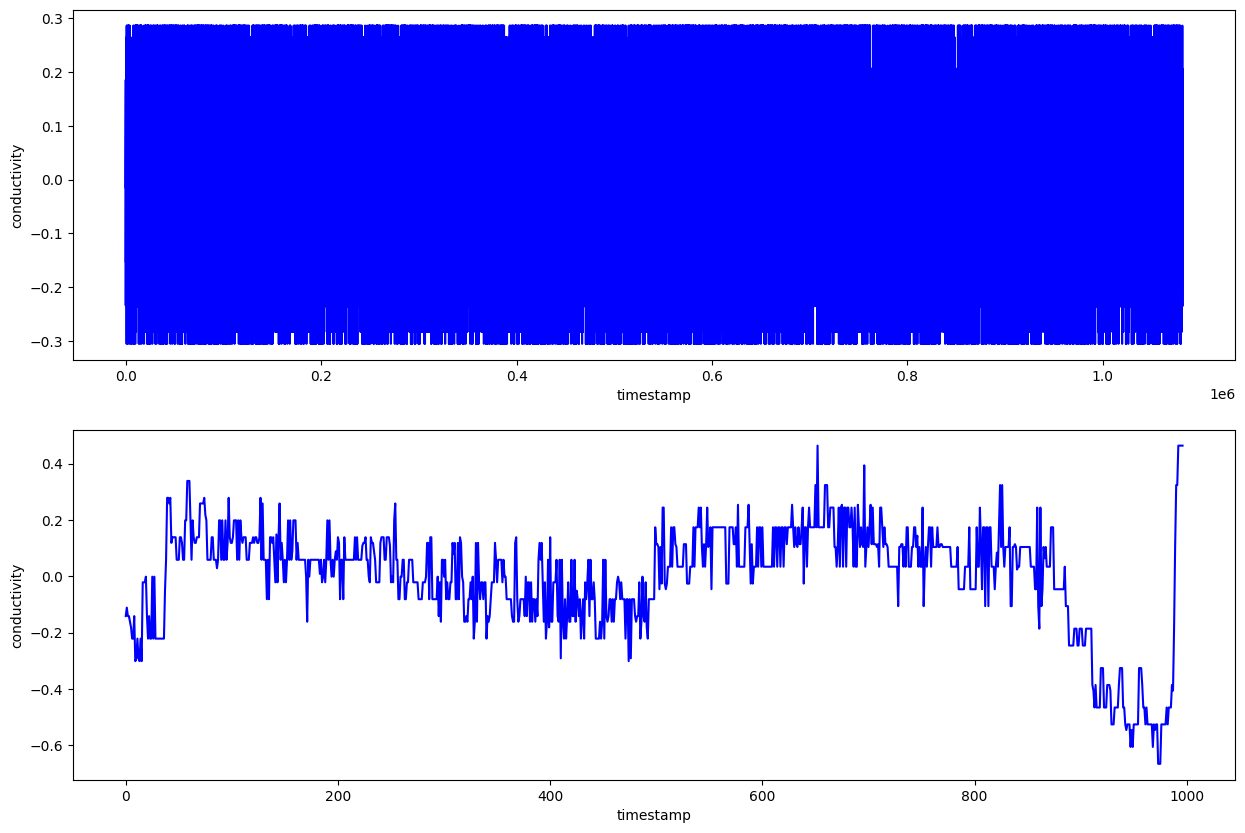

In [30]:
# Data visualization
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.lineplot(data=train_conduct, x='timestamp', y='conductivity', color='blue', ax=ax[0])
#ax1 = sns.scatterplot(data=train_anomalies, x='timestamp', y='stand_value', color='red', ax=ax[0])

ax2 = sns.lineplot(data=valid_conduct, x='timestamp', y='conductivity', color='blue', ax=ax[1])
#ax2 = sns.scatterplot(data=valid_anomalies, x='timestamp', y='stand_value', color='red', ax=ax[1])
plt.show()

In [31]:
# Function to create sequences remains the same
def create_sequences(data, time_steps):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
    return np.array(X)


def create_x_y_sequences(df, data,  time_steps):
    # Extract `run_id`s
    run_id = df['run_id'].unique()

    X = []

    # Iterate over each `run_id` to create sequences of data for that run and append to X_train
    for rid in run_id:
       idx = df[df['run_id'] == rid].index
       run_data = data.iloc[idx, :]['conductivity'].values
       run_sequences = create_sequences(run_data, time_steps)
       X.append(run_sequences)
    
    X = np.vstack(X)
    
    # For autoencoder, input = output
    Y = X.copy()

    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float64)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1).astype(np.float64)

    # Verify the shapes
    print(f"Training sequences shape: {X.shape}")
    print(f"Training labels shape: {Y.shape}")
    
    return X, Y

In [48]:
# 1. Creating sequences from training data
TIME_STEPS = 100 # Number of past time steps to look at

X_train, Y_train = create_x_y_sequences(train_c, train_conduct, TIME_STEPS)
X_valid, Y_valid = create_x_y_sequences(valid_c, valid_conduct, TIME_STEPS)

Training sequences shape: (881194, 100, 1)
Training labels shape: (881194, 100, 1)
Training sequences shape: (797, 100, 1)
Training labels shape: (797, 100, 1)


In [49]:
# 2. Create your dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) # (X, y)

# 3. Define augmentation functions
def augment_noise(x, y):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.01, dtype=X_train.dtype)
    return x + noise, y # Augment X, but keep y the same

def augment_scale(x, y):
    scaler = tf.random.uniform(shape=(), minval=0.9, maxval=1.1, dtype=X_train.dtype)
    return x * scaler, y

# 4. Chain the augmentations
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)
train_ds = train_ds.map(augment_noise, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment_scale, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 100, 1), dtype=tf.float64, name=None))>

In [50]:
# [a for a in train_ds.as_numpy_iterator()]
list(train_ds.as_numpy_iterator())

[(array([[[ 0.01223582],
          [ 0.19383677],
          [-0.03319122],
          ...,
          [-0.07801032],
          [ 0.14040113],
          [-0.08887768]],
  
         [[-0.0171947 ],
          [ 0.01667169],
          [ 0.04815878],
          ...,
          [ 0.1310289 ],
          [ 0.15690007],
          [ 0.05186498]],
  
         [[-0.10215265],
          [-0.10648241],
          [ 0.12720239],
          ...,
          [ 0.05084157],
          [ 0.04968115],
          [ 0.05654645]],
  
         ...,
  
         [[-0.0898941 ],
          [ 0.21424044],
          [-0.01188881],
          ...,
          [-0.01832445],
          [-0.00618762],
          [ 0.06731536]],
  
         [[-0.00504475],
          [ 0.01164242],
          [ 0.04751848],
          ...,
          [-0.08899377],
          [-0.10346594],
          [-0.1041549 ]],
  
         [[ 0.08973946],
          [ 0.08303121],
          [ 0.06415886],
          ...,
          [ 0.00185277],
          [-0.06971407]

In [51]:
# Print dataset lengths
print("raw train rows:", len(train_conduct))
print("raw valid rows:", len(valid_conduct))

# Print sequence shapes (must run after sequence creation)
print("X_train.shape:", X_train.shape)   # expect (n_samples, TIME_STEPS, 1)
print("Y_train.shape:", Y_train.shape)   # expect same as X_train
print("X_valid.shape:", X_valid.shape)
print("Y_valid.shape:", Y_valid.shape)

# Check min samples vs batch/validation
n_samples = X_train.shape[0]
print("n_samples:", n_samples)
print("batch_size:", 32)
print("n_samples < batch_size?", n_samples < 32)
print("n_samples * (1 - validation_split) approx:", n_samples * 0.9)

raw train rows: 1081494
raw valid rows: 997
X_train.shape: (881194, 100, 1)
Y_train.shape: (881194, 100, 1)
X_valid.shape: (797, 100, 1)
Y_valid.shape: (797, 100, 1)
n_samples: 881194
batch_size: 32
n_samples < batch_size? False
n_samples * (1 - validation_split) approx: 793074.6


## Model Training

In [56]:
# Define the model architecture
model = Sequential([
    # Encoder
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dropout(rate=0.2),
    
    # This layer repeats the learned representation for each time step
    # so the decoder can reconstruct the original sequence.
    RepeatVector(X_train.shape[1]),
    
    # Decoder
    LSTM(64, return_sequences=True),
    LSTM(128, return_sequences=True),
    Dropout(rate=0.2),
    
    # The output layer that reconstructs the input
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mae')
model.summary()

c:\Users\Admin\Desktop\Poom\PlateMon_data_analytics\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 100, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=(X_valid, Y_valid),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    shuffle=False
)

Epoch 1/50


27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3165s 115ms/step - loss: 0.0600 - val_loss: 0.0914
Epoch 2/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3146s 114ms/step - loss: 0.0513 - val_loss: 0.0906
Epoch 3/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3118s 113ms/step - loss: 0.0507 - val_loss: 0.0930
Epoch 4/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3118s 113ms/step - loss: 0.0509 - val_loss: 0.0973
Epoch 5/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3139s 114ms/step - loss: 0.0508 - val_loss: 0.0889
Epoch 6/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3181s 116ms/step - loss: 0.0512 - val_loss: 0.0909
Epoch 7/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3205s 116ms/step - loss: 0.0514 - val_loss: 0.0861
Epoch 8/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3165s 115ms/step - loss: 0.0498 - val_loss: 0.0899
Epoch 9/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3158s 115ms/step - loss: 0.0492 - val_loss: 0.0888
Epoch 10/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3435s 125ms/step - loss: 0.0489 - val_loss: 0.0870
Epoch 11/50
27538/27538 ━━━━━━━━━━━━━━━━━━━━ 3535s 128ms/ste

In [58]:
# Predict on the training data to get the reconstruction error for "normal" data
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Set the anomaly threshold based on the training data's loss distribution
# A common approach is to use a high percentile (e.g., 99th)
threshold = np.quantile(train_mae_loss, 0.99)

print(f"Anomaly threshold set to: {threshold}")

# Create a DataFrame with the train loss
train_loss_df = pd.DataFrame(index=range(len(train_mae_loss)))
train_loss_df['reconstruction_error'] = train_mae_loss

# Identify anomalies in the train set
train_loss_df['anomaly'] = train_loss_df['reconstruction_error'] > threshold

# Find the indices of the anomalous sequences
train_anomalies_idxs = train_loss_df[train_loss_df['anomaly']].index

# Map these sequence indices back to the original validation DataFrame indices
# The anomaly is at the end of the sequence window
anomalous_data_indices = []
for seq_idx in train_anomalies_idxs:
    anomalous_data_indices.append(seq_idx + TIME_STEPS - 1)

# Add an anomaly flag to your original validation DataFrame
# Note: The first `TIME_STEPS` rows of valid_df won't have a prediction
train_conduct['anomaly'] = False
train_conduct.iloc[anomalous_data_indices] = train_conduct.iloc[anomalous_data_indices].assign(anomaly=True)

27538/27538 ━━━━━━━━━━━━━━━━━━━━ 1104s 40ms/step
Anomaly threshold set to: 0.0720460385867132


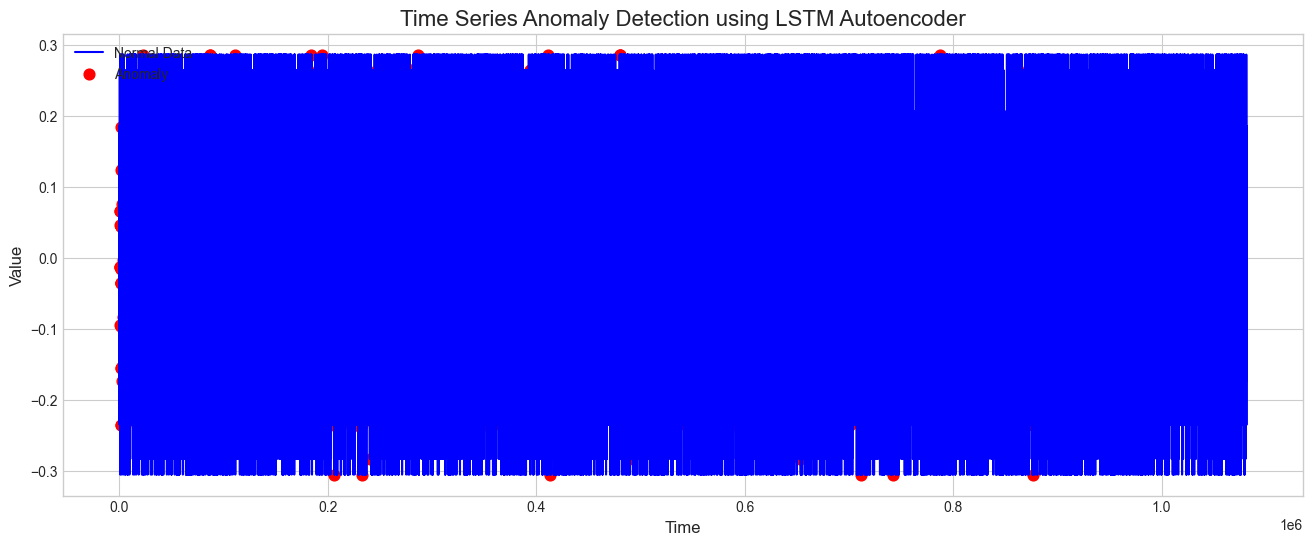

In [59]:
# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the original data
ax.plot(train_conduct.index, train_conduct['conductivity'], color='blue', label='Normal Data')

# Highlight the anomalies
anomalies = train_conduct[train_conduct['anomaly'] == True]
ax.scatter(anomalies.index, anomalies['conductivity'], color='red', marker='o', s=60, label='Anomaly')

ax.set_title('Time Series Anomaly Detection using LSTM Autoencoder', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='upper left')
plt.show()

In [ ]:
# Predict on the validation data
X_valid_pred = model.predict(X_valid)
valid_mae_loss = np.mean(np.abs(X_valid_pred - X_valid), axis=1).flatten()

best_f1 = 0
best_threshold = 0

# Test 100 different thresholds
thresholds = np.linspace(np.min(valid_mae_loss), np.max(valid_mae_loss), 100)

for threshold in thresholds:
    # 1 if error > threshold (anomaly), 0 otherwise
    predictions = (valid_mae_loss > threshold).astype(int)
    
    f1 = f1_score(valid_conduct['anomaly_label'], predictions)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1}")

# Create a DataFrame with the validation loss
loss_df = pd.DataFrame(index=range(len(valid_mae_loss)))
loss_df['reconstruction_error'] = valid_mae_loss

# Identify anomalies in the validation set
loss_df['anomaly'] = loss_df['reconstruction_error'] > best_threshold

# Find the indices of the anomalous sequences
valid_anomalies_idxs = loss_df[loss_df['anomaly']].index

# Map these sequence indices back to the original validation DataFrame indices
# The anomaly is at the end of the sequence window
anomalous_data_indices = []
for seq_idx in valid_anomalies_idxs:
    anomalous_data_indices.append(seq_idx + TIME_STEPS - 1)

# Add an anomaly flag to your original validation DataFrame
# Note: The first `TIME_STEPS` rows of valid_df won't have a prediction
valid_conduct['anomaly'] = False
valid_conduct.iloc[anomalous_data_indices] = ssvalid_conduct.iloc[anomalous_data_indices].assign(anomaly=True)

print("Anomalies found in the validation set:")
print(valid_conduct[valid_conduct['anomaly']])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


ValueError: Found input variables with inconsistent numbers of samples: [997, 797]

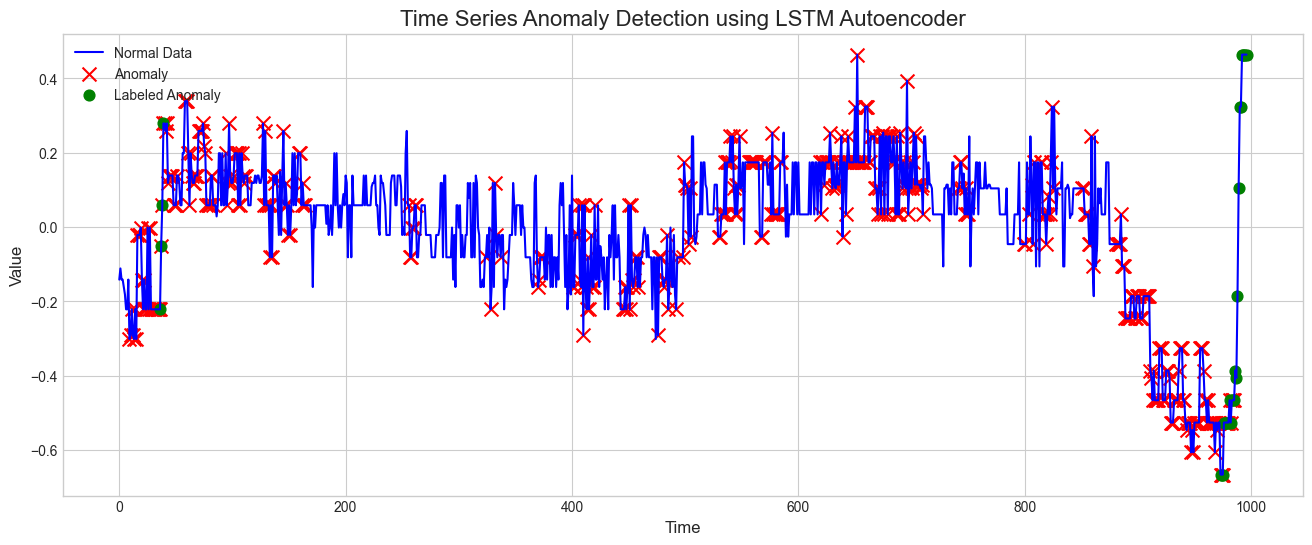

In [63]:
# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the original data
ax.plot(valid_conduct.index, valid_conduct['conductivity'], color='blue', label='Normal Data')

# Highlight the anomalies
anomalies = valid_conduct[valid_conduct['anomaly'] == True]
labeled = valid_conduct[valid_conduct['anomaly_label'] == 1]
ax.scatter(anomalies.index, anomalies['conductivity'], color='red', marker='x', s=100, label='Anomaly')
ax.scatter(labeled.index, labeled['conductivity'], color='green', marker='o', s=60, label='Labeled Anomaly')

ax.set_title('Time Series Anomaly Detection using LSTM Autoencoder', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='upper left')
plt.show()

## Confusion metrics

In [ ]:
# except confusion matrix
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list
    ):
    predictions = pd.DataFrame(
        index=range(len(ground_truth)), 
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # Calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        margins=True
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        beta=2., 
        average='binary'
    )
    return confusion_matrix, precision, recall, f1

In [ ]:
train_conduct['anomaly_label'] = 0

train_conf_matrix, *train_metrics = calculate_metrics(
    train_conduct, train_anomalies_idxs
)

# Pretty printing of the metrics
print(f'Train:\n Precision: {train_metrics[0]:.3f}\n' 
      f'Recall: {train_metrics[1]:.3f}\n' 
      f'F2 score: {train_metrics[2]:.3f}\n'
      f'{train_conf_matrix}')

Train:
 Precision: 0.000
Recall: 0.000
F2 score: 0.000
anomaly_predicted        0      1      All
anomaly_label                             
0                  1070879  10615  1081494
All                1070879  10615  1081494


c:\Users\Admin\Desktop\Poom\PlateMon_data_analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
valid_conf_matrix, *valid_metrics = calculate_metrics(
    valid_conduct, valid_anomalies_idxs
)

print(f'Valid:\n Precision: {valid_metrics[0]:.3f}\n' 
      f'Recall: {valid_metrics[1]:.3f}\n' 
      f'F2 score: {valid_metrics[2]:.3f}\n'
      f'{valid_conf_matrix}')

Valid:
 Precision: 0.017
Recall: 0.286
F2 score: 0.070
anomaly_predicted    0    1  All
anomaly_label                   
0                  519  450  969
1                   20    8   28
All                539  458  997
